# MODIS Level 2 AOD - Single File Processing and Visualization

## About

This notebook demonstrates loading data from a single MODIS Level 2 (MYD04_L2 or MOD04_L2) HDF4 file. It focuses on:
1. Extracting latitude, longitude, Aerosol Optical Depth at 550nm, and Quality Flags.
2. Calculating date and time from `Scan_Start_Time`.
3. Visualizing an AOD map (filtered by good quality flags, QA=3).
4. Saving the extracted and processed pixel data to an ASCII (CSV) file.

## Step 1: Load Python Libraries

In [1]:
from pyhdf.SD import SD, SDC 
import numpy as np      
import os                    
import datetime              

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Step 2: User Settings and File Path

In [2]:
# --- User Settings --- #
# *** DEFINE THE FULL PATH TO YOUR SINGLE MODIS HDF FILE HERE ***
modis_file_path = '../data/modis_aod/MYD04_L2.A2025141.0830.061.2025141192432.hdf' # Example path

output_image_dir = '../output/images/' 
output_ascii_dir = '../output/ascii/'   

lat_sds_name = 'Latitude'
lon_sds_name = 'Longitude'
aod_sds_name = 'Optical_Depth_Land_And_Ocean' 
qa_sds_name = 'Land_Ocean_Quality_Flag'      
time_sds_name = 'Scan_Start_Time'
# --- End User Settings --- #

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_ascii_dir, exist_ok=True)

data_loaded_successfully = False
base_filename_for_output = "MODIS_AOD_Single_NoData"
if not os.path.exists(modis_file_path):
    print(f"Error: File not found at {modis_file_path}")
else:
    print(f"Processing file: {modis_file_path}")
    data_loaded_successfully = True 
    base_filename_for_output = os.path.splitext(os.path.basename(modis_file_path))[0]

Processing file: ../data/modis_aod/MYD04_L2.A2025141.0830.061.2025141192432.hdf


## Step 3: Load Data using `pyhdf`, Process, and Prepare for Plotting/Saving

In [3]:
latitude_granule_for_plot = None # For map grid coordinates
longitude_granule_for_plot = None # For map grid coordinates
aot550_qa_filtered_granule = None # For map color data

ascii_pixels_datetime = []
ascii_pixels_lat = []
ascii_pixels_lon = []
ascii_pixels_aot = []
ascii_pixels_qf = []

var_attributes = {}
map_extent_calculated = False
global_lat_min, global_lat_max, global_lon_min, global_lon_max = None, None, None, None

if data_loaded_successfully: 
    hdf = None
    try:
        hdf = SD(modis_file_path, SDC.READ)
        print(f"  Successfully opened file: {os.path.basename(modis_file_path)}")
        
        lat_sds = hdf.select(lat_sds_name)
        latitude_granule_raw = lat_sds[:,:] 
        lon_sds = hdf.select(lon_sds_name)
        longitude_granule_raw = lon_sds[:,:] 

        aod_sds = hdf.select(aod_sds_name)
        aot550_raw_granule = aod_sds[:,:].astype(np.double) 
        
        qa_sds = hdf.select(qa_sds_name)
        qf_raw_granule = qa_sds[:,:] 
        
        time_sds = hdf.select(time_sds_name)
        scan_start_time_raw = time_sds[:] 

        aod_attrs = aod_sds.attributes(full=1)
        var_attributes['AOT550_long_name'] = aod_attrs.get("long_name", [aod_sds_name])[0]
        var_attributes['AOT550_units'] = str(aod_attrs.get("units", ["1"])[0])
        var_attributes['AOT550_fill_value'] = aod_attrs.get("_FillValue", [-9999])[0]
        var_attributes['AOT550_scale_factor'] = aod_attrs.get("scale_factor", [1.0])[0]
        var_attributes['AOT550_add_offset'] = aod_attrs.get("add_offset", [0.0])[0]

        qa_attrs = qa_sds.attributes(full=1)
        var_attributes['QF_fill_value'] = qa_attrs.get("_FillValue", [-9999])[0]
        
        lat_attrs = lat_sds.attributes(full=1)
        lon_attrs = lon_sds.attributes(full=1)
        var_attributes['Geo_Lat_fill_value'] = lat_attrs.get("_FillValue", [-9999.0])[0]
        var_attributes['Geo_Lon_fill_value'] = lon_attrs.get("_FillValue", [-9999.0])[0]

        aot_fill_from_attr = var_attributes['AOT550_fill_value']
        aot_scale = var_attributes['AOT550_scale_factor']
        aot_offset = var_attributes['AOT550_add_offset']
        qf_fill_from_attr = var_attributes['QF_fill_value']
        geo_lat_fill_from_attr = var_attributes['Geo_Lat_fill_value']
        geo_lon_fill_from_attr = var_attributes['Geo_Lon_fill_value']

        aot_processed_granule = np.where(aot550_raw_granule == aot_fill_from_attr, np.nan, aot550_raw_granule)
        aot_calibrated_granule = (aot_processed_granule - aot_offset) * aot_scale

        qf_processed_granule = np.where(qf_raw_granule == qf_fill_from_attr, -1, qf_raw_granule).astype(np.int8)
        aot550_qa_filtered_granule = np.where(qf_processed_granule == 3, aot_calibrated_granule, np.nan)

        latitude_granule_for_plot = latitude_granule_raw 
        longitude_granule_for_plot = longitude_granule_raw

        valid_lons = longitude_granule_raw[(longitude_granule_raw != geo_lon_fill_from_attr) & (~np.isnan(longitude_granule_raw))]
        valid_lats = latitude_granule_raw[(latitude_granule_raw != geo_lat_fill_from_attr) & (~np.isnan(latitude_granule_raw))]
        if valid_lons.size > 0 and valid_lats.size > 0:
            global_lon_min, global_lon_max = np.nanmin(valid_lons), np.nanmax(valid_lons)
            global_lat_min, global_lat_max = np.nanmin(valid_lats), np.nanmax(valid_lats)
            map_extent_calculated = True
            print("Map extent calculated:")
            print(f"  Longitude: {global_lon_min:.2f} to {global_lon_max:.2f}")
            print(f"  Latitude:  {global_lat_min:.2f} to {global_lat_max:.2f}")
        else:
            print("Warning: No valid longitude/latitude data for extent.")
            data_loaded_successfully = False 

        if scan_start_time_raw.ndim == 1 and len(scan_start_time_raw) == latitude_granule_raw.shape[0]:
            scan_start_time_pixel_granule = np.repeat(scan_start_time_raw[:, np.newaxis], latitude_granule_raw.shape[1], axis=1)
        elif scan_start_time_raw.shape == latitude_granule_raw.shape:
            scan_start_time_pixel_granule = scan_start_time_raw
        else:
            print(f"  Warning: Scan_Start_Time shape {scan_start_time_raw.shape} not directly compatible. Assigning NaNs.")
            scan_start_time_pixel_granule = np.full_like(latitude_granule_raw, np.nan, dtype=float)

        epoch = datetime.datetime(1993, 1, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)
        for y_idx in range(latitude_granule_raw.shape[0]):
            for x_idx in range(latitude_granule_raw.shape[1]):
                current_aot_val = aot550_qa_filtered_granule[y_idx, x_idx]
                current_qf_val = qf_processed_granule[y_idx, x_idx]
                current_lat_val = latitude_granule_raw[y_idx, x_idx]
                current_lon_val = longitude_granule_raw[y_idx, x_idx]
                
                if current_qf_val == 3 and not np.isnan(current_aot_val) and \
                   current_lat_val != geo_lat_fill_from_attr and not np.isnan(current_lat_val) and \
                   current_lon_val != geo_lon_fill_from_attr and not np.isnan(current_lon_val):
                    
                    time_val_seconds = scan_start_time_pixel_granule[y_idx, x_idx]
                    dt_obj = None
                    if not np.isnan(time_val_seconds):
                        try:
                            dt_obj = epoch + datetime.timedelta(seconds=float(time_val_seconds))
                        except (ValueError, TypeError):
                            dt_obj = None 
                    if dt_obj is not None:
                        ascii_pixels_datetime.append(dt_obj)
                        ascii_pixels_lat.append(current_lat_val)
                        ascii_pixels_lon.append(current_lon_val)
                        ascii_pixels_aot.append(current_aot_val)
                        ascii_pixels_qf.append(current_qf_val)
        
        print(f"\nSuccessfully processed data from {modis_file_path}")

    except Exception as e:
        print(f"Error processing file {modis_file_path}: {e}")
        data_loaded_successfully = False
    finally:
        if hdf:
            hdf.end()
            print(f"  HDF file {os.path.basename(modis_file_path)} has been closed.")
else:
    print("File path was not valid initially or file not found. Nothing to process.")

print("Data loading and processing complete.")

  Successfully opened file: MYD04_L2.A2025141.0830.061.2025141192432.hdf
Map extent calculated:
  Longitude: 78.25 to 102.39
  Latitude:  -0.23 to 20.52

Successfully processed data from ../data/modis_aod/MYD04_L2.A2025141.0830.061.2025141192432.hdf
  HDF file MYD04_L2.A2025141.0830.061.2025141192432.hdf has been closed.
Data loading and processing complete.


## Step 4: Visualize and Save AOD Map
Aerosol Optical Depth is filtered where `Quality_Flag == 3` ('Very Good').

AOD Map saved to: ../output/images/MYD04_L2.A2025141.0830.061.2025141192432_AOT550_QA3.png


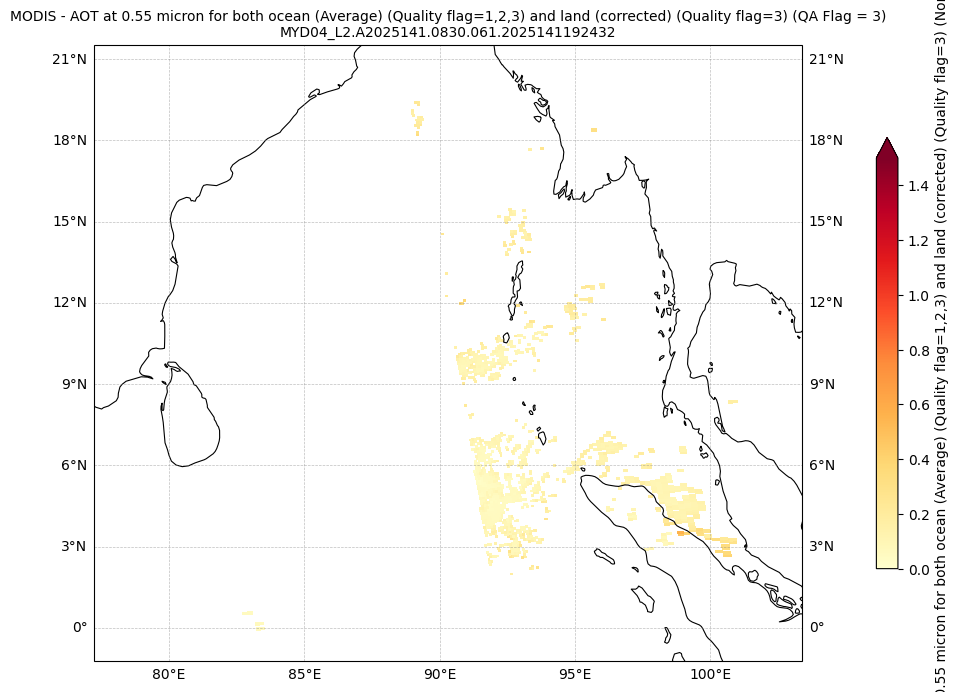

In [4]:
if data_loaded_successfully and map_extent_calculated and latitude_granule_for_plot is not None and aot550_qa_filtered_granule is not None:
    extent_padding_val = 1.0 
    map_extent_plot = [global_lon_min - extent_padding_val, global_lon_max + extent_padding_val, 
                       global_lat_min - extent_padding_val, global_lat_max + extent_padding_val]

    fig = plt.figure(figsize=(12, 8)) 
    ax = plt.axes(projection=ccrs.PlateCarree())
    try:
        ax.set_extent(map_extent_plot, crs=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error setting map extent {map_extent_plot}: {e}. Using global extent.")
        ax.set_global()
    
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = True 
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    plotted_mesh_aod = None 
    aod_to_plot = aot550_qa_filtered_granule 

    if aod_to_plot.size > 0 and np.any(~np.isnan(aod_to_plot)):
        mesh = ax.pcolormesh(longitude_granule_for_plot, latitude_granule_for_plot, aod_to_plot, 
                             transform=ccrs.PlateCarree(), 
                             cmap='YlOrRd', 
                             vmin=0, 
                             vmax=1.5, 
                             shading='auto')
        plotted_mesh_aod = mesh
    
    aot550_display_long_name = var_attributes.get('AOT550_long_name', 'AOT at 550nm')
    aot550_display_units = var_attributes.get('AOT550_units', '1')
    title_str_prefix = f'MODIS - {aot550_display_long_name} (QA Flag = 3)'
    title_str_suffix = base_filename_for_output

    if plotted_mesh_aod is not None:
        cbar = plt.colorbar(plotted_mesh_aod, ax=ax, orientation='vertical', pad=0.08, shrink=0.7, extend='max')
        cbar.set_label(f"{aot550_display_long_name} ({aot550_display_units})")
        plt.title(f'{title_str_prefix}\n{title_str_suffix}', fontsize=10)
    else:
        print("No valid AOD data to plot for this file.")
        plt.title(f'{title_str_prefix}\nNo valid data in {title_str_suffix}', fontsize=10)
    
    save_filename_aod = f"{base_filename_for_output}_AOT550_QA3.png"
    full_save_path_aod = os.path.join(output_image_dir, save_filename_aod)
    plt.savefig(full_save_path_aod, dpi=300, bbox_inches='tight') 
    print(f"AOD Map saved to: {full_save_path_aod}")
    plt.show() 
    plt.close(fig)
else:
    print("Skipping AOD map plotting: Data not loaded, map extent not calculated, or no plottable AOD data.")

## Step 5: Save Extracted Data to ASCII (CSV) File
Saves datetime, latitude, longitude, quality-filtered AOD (where QF=3), and the quality flag itself for all valid pixels from the single file.

In [5]:
if data_loaded_successfully and ascii_pixels_datetime:
    ascii_filename = f"{base_filename_for_output}_pixel_data.csv"
    full_ascii_path = os.path.join(output_ascii_dir, ascii_filename)

    print(f"\nSaving valid pixel data to ASCII file: {full_ascii_path}")
    with open(full_ascii_path, 'w') as f:
        f.write("Datetime,Latitude,Longitude,AOT550_QA3,QualityFlag\n")
        
        for i in range(len(ascii_pixels_datetime)):
            dt_obj = ascii_pixels_datetime[i]
            lat_val = ascii_pixels_lat[i]
            lon_val = ascii_pixels_lon[i]
            aot_val = ascii_pixels_aot[i]
            qf_val = ascii_pixels_qf[i]
            
            dt_str = dt_obj.strftime('%Y-%m-%dT%H:%M:%S.%fZ') 
            f.write(f"{dt_str},{lat_val:.4f},{lon_val:.4f},{aot_val:.4f},{int(qf_val)}\n")
            
        print(f"Finished writing ASCII file. {len(ascii_pixels_datetime)} valid data points written.")
else:
    print("Skipping ASCII file generation: No valid data points were processed or data loading failed.")


Saving valid pixel data to ASCII file: ../output/ascii/MYD04_L2.A2025141.0830.061.2025141192432_pixel_data.csv
Finished writing ASCII file. 1246 valid data points written.


## End of Processing

In [6]:
print("MODIS Single File Data Processing Complete.")

MODIS Single File Data Processing Complete.
